#Mounted Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset folder structure



In [ ]:
"""
MyDrive/Dataset
- Draw
  - 140k
    - train
      - fake_10k.raz
      - real_10k.raz
  - faceforensics
    - original_sequences
      - youtube
        - c23
          - videos
    - manipulated_sequences
      - youtube
        - c23
          - videos
- Processed
  - 140k
    - real
    - fake
  - faceforensics
    - real
    - fake
"""

#Unraz 140k Real & Fake Images


In [ ]:
#  Unraz 140k Real & Fake Image
!unrar x "/content/drive/MyDrive/Dataset/Draw/140k/train/real_10k.rar" "/content/drive/MyDrive/Dataset/Processed/140k"
print('DONE Real')

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63109.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63110.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63111.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63113.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63114.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63115.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63116.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63117.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63118.jpg      89%  OK 
Extracting  /content/drive/MyDrive/Dataset/Processed/140k/real/63119.jpg     

In [ ]:
!unrar x "/content/drive/MyDrive/Dataset/Draw/140k/train/fake_10k.rar" "/content/drive/MyDrive/Dataset/Processed/140k"
print('DONE Fake')

In [ ]:
import os
print(len(os.listdir('/content/drive/MyDrive/Dataset/Processed/140k/real')))

50000


#Crop best face 20k from 140k images


In [ ]:
import cv2
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from blazeface import BlazeFace

root = '/content/drive/MyDrive'

sys.path.insert(0, os.path.join(root, 'Colab Notebooks', 'Final project', 'blazeface-pytorch'))
sys.path.insert(0, os.path.join(root, 'Colab Notebooks', 'Final project'))

gpu = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
gpu

facedet = BlazeFace().to(gpu)
facedet.load_weights(os.path.join(root, 'Colab Notebooks', 'Final project', "blazeface.pth"))
facedet.load_anchors(os.path.join(root, 'Colab Notebooks', 'Final project', "anchors.npy"))

facedet.min_score_thresh = 0.75
facedet.min_suppression_threshold = 0.3

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)

    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])

    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        face = img[ymin.astype(np.int):ymax.astype(np.int), xmin.astype(np.int):xmax.astype(np.int), :]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none",
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1,
                                        edgecolor="lightskyblue", facecolor="none",
                                        alpha=detections[i, 16])
                ax.add_patch(circle)

    plt.show()
    return face

In [ ]:
def add_margin_to_detections(detections, frame_size, margin=0.2):
      offset = torch.round(margin * (detections[:, 2] - detections[:, 0]))
      detections = detections.clone()
      detections[:, 0] = torch.clamp(detections[:, 0] - offset*2, min=0)            # ymin
      detections[:, 1] = torch.clamp(detections[:, 1] - offset, min=0)              # xmin
      detections[:, 2] = torch.clamp(detections[:, 2] + offset, max=frame_size[1])  # ymax
      detections[:, 3] = torch.clamp(detections[:, 3] + offset, max=frame_size[0])  # xmax
      return detections

def crop_faces(img, detections ):
    faces = []
    for i in range(len(detections)):
        ymin, xmin, ymax, xmax = detections[i, :4].cpu().numpy()
        ymin = ymin * img.shape[0]
        xmin = xmin * img.shape[1]
        ymax = ymax * img.shape[0]
        xmax = xmax * img.shape[1]
        face = img[ymin.astype(np.int):ymax.astype(np.int), xmin.astype(np.int):xmax.astype(np.int), :]
        faces.append(face)
    return faces

def keep_only_best_face(crops):
        for i in range(len(crops)):
            frame_data = crops[i]
            if len(frame_data["faces"]) > 0:
                frame_data["faces"] = frame_data["faces"][:1]
                frame_data["scores"] = frame_data["scores"][:1]


def detec_and_crop_best_face(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = cv2.resize(img, facedet.input_size, interpolation = cv2.INTER_AREA)

  target_size = facedet.input_size
  frame_size = (img.shape[1], img.shape[0])

  detections = facedet.predict_on_image(img)
  faces = add_margin_to_detections(detections, frame_size, 0.5)
  scores = detections[:, 16].cpu().numpy()

  faces = crop_faces(img, faces)

  return faces[np.where(scores == np.amax(scores))[0][0]]


In [ ]:
REAL_PATH = '/content/drive/MyDrive/Dataset/Draw/140k/real'
FAKE_PATH = '/content/drive/MyDrive/Dataset/Draw/140k/fake'
PROCCESSED_REAL_PATH = '/content/drive/MyDrive/Dataset/Processed/140k/real'
PROCCESSED_FAKE_PATH = '/content/drive/MyDrive/Dataset/Processed/140k/fake'

LIST_REAL = os.listdir(REAL_PATH)
LIST_FAKE = os.listdir(FAKE_PATH)

In [ ]:
for path in LIST_REAL:
  print(path)
  best_face = detec_and_crop_best_face(os.path.join(REAL_PATH, path))
  cv2.imwrite(os.path.join(PROCCESSED_REAL_PATH, path), best_face)

In [ ]:
for path in LIST_FAKE:
  print(path)
  best_face = detec_and_crop_best_face(os.path.join(FAKE_PATH, path))
  cv2.imwrite(os.path.join(PROCCESSED_FAKE_PATH, path), best_face)

In [ ]:
print(facedet.input_size)

(128, 128)


In [ ]:
%cd /content/drive/MyDrive/140k/train/proccessed
# os.mkdir('/content/drive/MyDrive/140k/train/proccessed/real')
# os.mkdir('/content/drive/MyDrive/140k/train/proccessed/fake')

/content/drive/MyDrive/140k/train/proccessed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


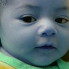

In [ ]:
import cv2
PATH = "/content/drive/MyDrive/140k/train/real/00000.jpg"

face = detec_and_crop_best_face(PATH)
from google.colab.patches import cv2_imshow
cv2_imshow(face)

#Crop faces from FaceForensics

In [ ]:
import numpy as np
import pandas as pd
import os
import os
import torch
import cv2
import time
from torch import nn
import matplotlib.pyplot as plt
import matplotlib
from torchvision.transforms import Normalize

gpu = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
gpu

device(type='cuda', index=0)

In [ ]:
root = '/content/drive/MyDrive'
# os.mkdir(os.path.join(root, 'img_data'))
# os.mkdir(os.path.join(root, 'img_data/DeepFakes'))
os.mkdir(os.path.join(root, 'img_data/Original'))
img_PATH=os.path.join(root, 'img_data')
frames_per_video = 10
input_size = 224
test_val_frac = 0.3

In [ ]:
print(os.listdir(img_PATH))

['DeepFakes', 'NeuralTextures']


In [ ]:
PATH=os.path.join(root, 'faceforensics')
deepFakes = os.listdir(os.path.join(PATH,'manipulated_sequences', 'Deepfakes','c23', 'videos'))
neuralTextures = os.listdir(os.path.join(PATH,'manipulated_sequences', 'NeuralTextures','c23', 'videos'))
original = os.listdir(os.path.join(PATH,'original_sequences','youtube','c23', 'videos'))
label = ['Original']*1000 + ['DeepFakes']*1000
video_df = pd.DataFrame()
video_df['filename'] = original + deepFakes
video_df['category'] = label
video_df.to_csv(os.path.join(root,'img_data/metadata.csv'))

In [ ]:
import sys
sys.path.insert(0, os.path.join(root, 'Colab Notebooks', 'blazeface-pytorch'))
sys.path.insert(0, os.path.join(root, 'Colab Notebooks'))
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights(os.path.join(root, 'Colab Notebooks', "blazeface.pth"))
facedet.load_anchors(os.path.join(root, 'Colab Notebooks', "anchors.npy"))
_ = facedet.train(False)
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

video_reader = VideoReader(verbose=True)
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [ ]:
%cd '/content/drive/MyDrive/img_data'

/content/drive/MyDrive/img_data


In [ ]:
img_PATH=os.path.join(PATH, 'img_data')
for index, row in video_df.iterrows():
    filename=row['filename']
    category=row['category']
    cap = ''
    if category=='DeepFakes':
        cap='manipulated_sequences/Deepfakess'
    else:
        cap='original_sequences/youtube'
    video_PATH = os.path.join(PATH, cap, 'c23', 'videos',filename)
    print(video_PATH)

    faces = face_extractor.process_video(video_PATH)
    face_extractor.keep_only_best_face(faces)
    if len(faces)>0:
        num=0
        for frame_data in faces:
            for face in frame_data['faces']:
                img_name = filename[:-4]+'_img_'+str(num)+'.jpg'
                print(img_name)
                cv2.imwrite(os.path.join(root, 'img_data/'+category+'/'+img_name), face)
                num+=1